## Import necessary libraries

In [3]:
# import necessary libraries
import numpy as np
import os
import pickle
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Để hình vẽ đẹp hơn một xíu ...
import seaborn as sns
plt.switch_backend('Agg')  # Use 'Agg' backend to avoid GUI interaction


## Load Dataset from local

### Load function

In [4]:
def load_mnist_from_local(mnist_file="mnist.pkl.gz"):
    # check if the file exists
    if not os.path.isfile(mnist_file):
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    # load the mnist dataset
    with gzip.open(mnist_file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    # split the data into train, validation and test sets
    (train_X, train_Y), (val_X, val_Y), (test_X, test_Y) = data
    
    # return
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

### Load dataset

In [5]:
# load the MNIST dataset
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_mnist_from_local()

### Explore dataset

In [6]:
# Check the shape of the data
print(f'Shape of train_X: {train_X.shape}, shape of train_Y: {train_Y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_Y:   {val_Y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_Y:  {test_Y.shape}')

# Check the number of classes
num_classes = len(np.unique(train_Y))
print(f'Number of classes: {num_classes}')

Shape of train_X: (50000, 28, 28), shape of train_Y: (50000,)
Shape of val_X:   (10000, 28, 28), shape of val_Y:   (10000,)
Shape of test_X:  (10000, 28, 28), shape of test_Y:  (10000,)
Number of classes: 10


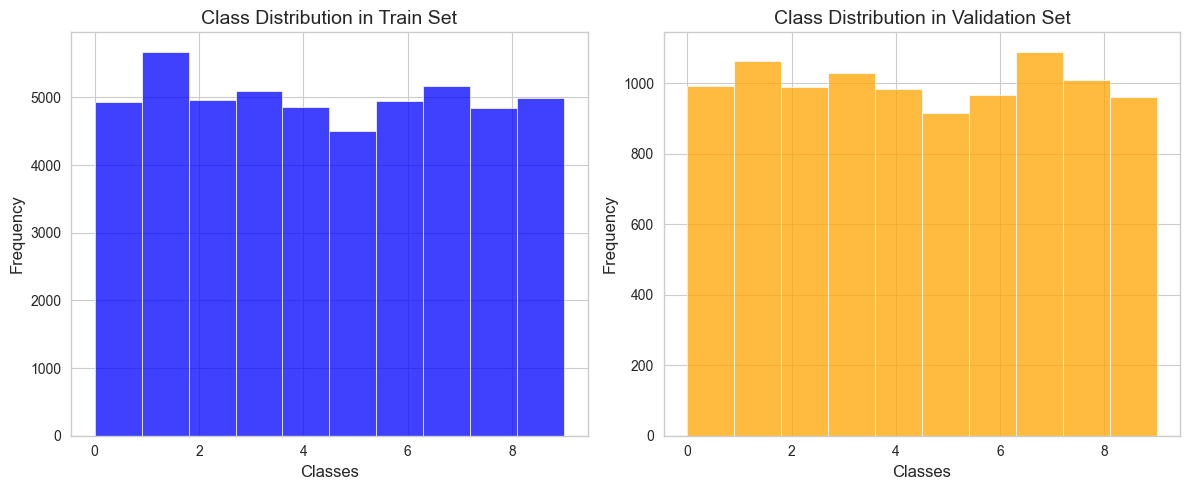

In [7]:
# Set style for better visualization
sns.set_style("whitegrid")

# Define figure size
plt.figure(figsize=(12, 5))

# Train set distribution
plt.subplot(1, 2, 1)
sns.histplot(train_Y, bins=num_classes, kde=False, color='blue')
plt.title('Class Distribution in Train Set', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Validation set distribution
plt.subplot(1, 2, 2)
sns.histplot(val_Y, bins=num_classes, kde=False, color='orange')
plt.title('Class Distribution in Validation Set', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

These classes distribution look pretty good.

In [8]:
# Check the type and range of pixel values
print(f"Data Type: {train_X.dtype}")
print(f"Pixel Range: Min = {train_X.min()}, Max = {train_X.max()}")


Data Type: uint8
Pixel Range: Min = 0, Max = 255


So MNISTs' images are 28x28 grayscale image with range of value for each pixel is 0-255. 

Text(0.5, 0.98, 'Randomly Selected Images from Training Set')

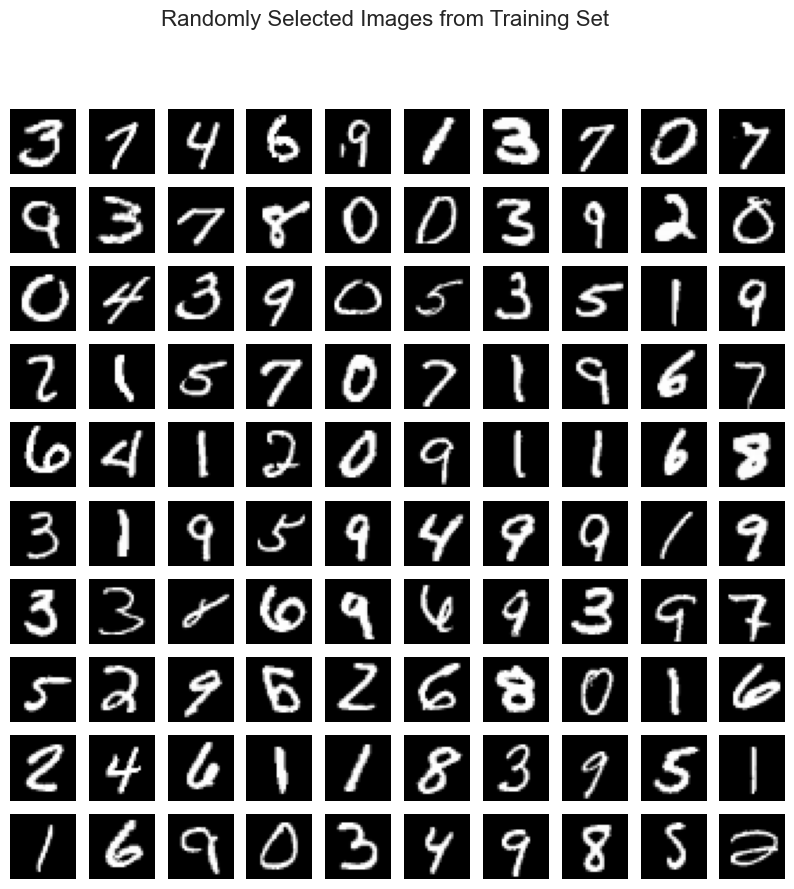

In [9]:
# Choose 100 random indices
random_indices = np.random.choice(train_X.shape[0], 100, replace=False)

# Visualize 100 images randomly from the training set
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(train_X[random_indices[i]].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Randomly Selected Images from Training Set', fontsize=16)

Now let's do the preprocessing data before training.

## Preprocessing

### Flattern images

In [10]:
# flatten the images
flattened_train_X = train_X.reshape(train_X.shape[0], -1)
flattened_val_X = val_X.reshape(val_X.shape[0], -1)
flattened_test_X = test_X.reshape(test_X.shape[0], -1)

# Check the shape of the flattened data
print(f'Shape of flattened_train_X: {flattened_train_X.shape}')
print(f'Shape of flattened_val_X:   {flattened_val_X.shape}')
print(f'Shape of flattened_test_X:  {flattened_test_X.shape}')

Shape of flattened_train_X: (50000, 784)
Shape of flattened_val_X:   (10000, 784)
Shape of flattened_test_X:  (10000, 784)


### Normalize data

In [11]:
# Normalize the pixel values
flattened_train_X = flattened_train_X / 255.0
flattened_val_X = flattened_val_X / 255.0
flattened_test_X = flattened_test_X

# Check the pixel range after normalization
print(f"Pixel Range: Min = {flattened_train_X.min()}, Max = {flattened_train_X.max()}")

Pixel Range: Min = 0.0, Max = 1.0


This is quite good but there are somethings that can be improved. Let's see:
- Images are grayscale => we can add intensity feature to data
- Images are numbers => some numbers can be symmetry => add symmetry feature to data

### Add features

In [12]:
# compute intensity
def compute_intensity(X):
    return np.mean(X, axis=1)

# compute symmetry
def compute_symmetry(X):
    data_num = X.shape[0]

    # reshape the images for calculating symmetry
    images = X.reshape(-1, 28, 28)

    # symmetry = (vertical_symmetry + horizontal_symmetry) / 2
    # vertical symmetry and horizontal symmetry
    vertical_symmetry = np.zeros(data_num)
    horizontal_symmetry = np.zeros(data_num)

    # compute symmetry
    for i in range(data_num):
        img = images[i]
        # vertical symmetry = difference between image and up-down flipped image
        vertical_symmetry[i] = np.mean(np.abs(img - np.flipud(img)))
        # horizontal symmetry = difference between image and left-right flipped image
        horizontal_symmetry[i] = np.mean(np.abs(img - np.fliplr(img)))
    
    symmetries = (vertical_symmetry + horizontal_symmetry) / 2
    return symmetries


Since the images are hand-written, so sometimes the intensity and symmetry may be wrongs. Therefore, we need to desclant the image for better symmetry and intensity calculation.

Text(0.5, 0.98, 'Randomly Selected Images of Class 8')

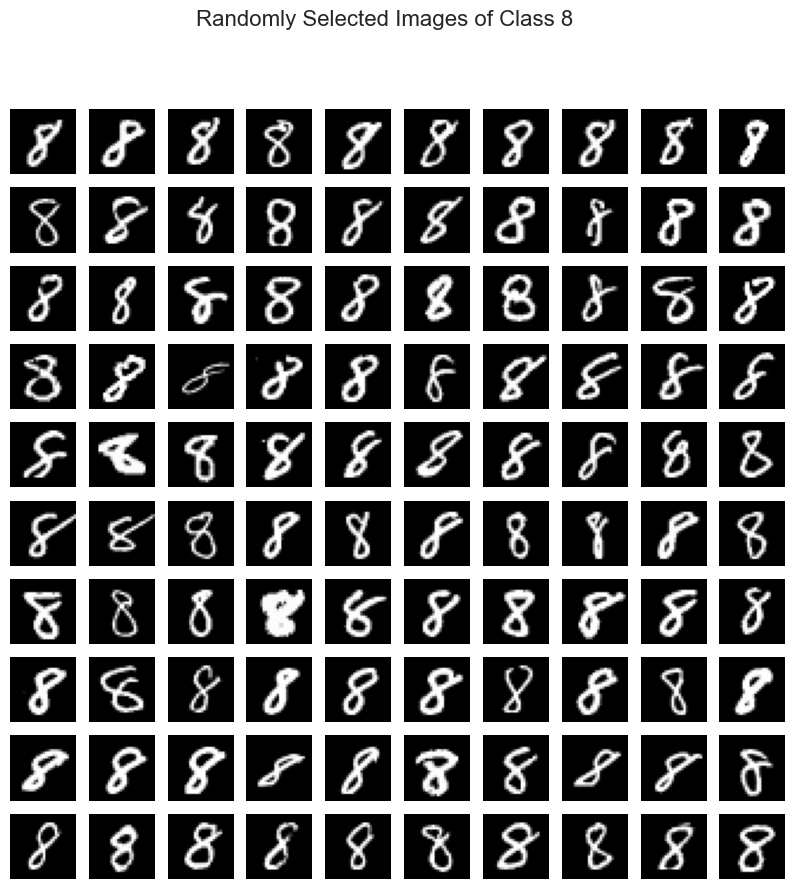

In [13]:
# Visualize the intensity and symmetry of the images (100  images of class 8)
# Choose 100 random indices of class 8
class_8_indices = np.where(train_Y == 8)[0]

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(train_X[class_8_indices[i]].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Randomly Selected Images of Class 8', fontsize=16)

### Desclant images

In [14]:
def deslant(X):
    # intialize the desclanted images
    deslanted_images = np.zeros_like(X)

    # desclant the images
    # loop through each image
    for i in range(X.shape[0]):
        img = X[i].reshape(28, 28)
        # find significant pixels (pixel value > 0.5)
        significant_pixels = np.argwhere(img > 0.5)

        # check if there are any significant pixels
        if len(significant_pixels) == 0:
            deslanted_images[i] = X[i]  # if no significant pixels, keep the image as it is
            continue

        # find the center of the significant pixels
        center = np.mean(significant_pixels, axis=0)

        # normalize the significant pixels
        normalized_pixels = (significant_pixels - center) / np.std(significant_pixels, axis=0)

        # shift the significant pixels
        tan_a = - np.corrcoef(normalized_pixels[:, 0], normalized_pixels[:, 1])[0, 1] * np.std(significant_pixels[:, 1], axis=0) / np.std(significant_pixels[:, 0], axis=0)
        for row in range (28):
            for col in range(28):
                ic = col + tan_a * (center[0] - row)
                if ic < 0:
                    ic = 0
                if ic > 27:
                    ic = 27
                ic_up = int(ic) + 1
                ic_down = int(ic)
                if ic_up > 27:
                    ic_up = 27
                con = ic_up - ic
                deslanted_images[i, row * 28 + col] = con * img[row, ic_down] + (1 - con) * img[row, ic_up]

    return deslanted_images


Now, let's visualize the images after deslanting.

Text(0.5, 0.98, 'Deslanted Images of Class 8')

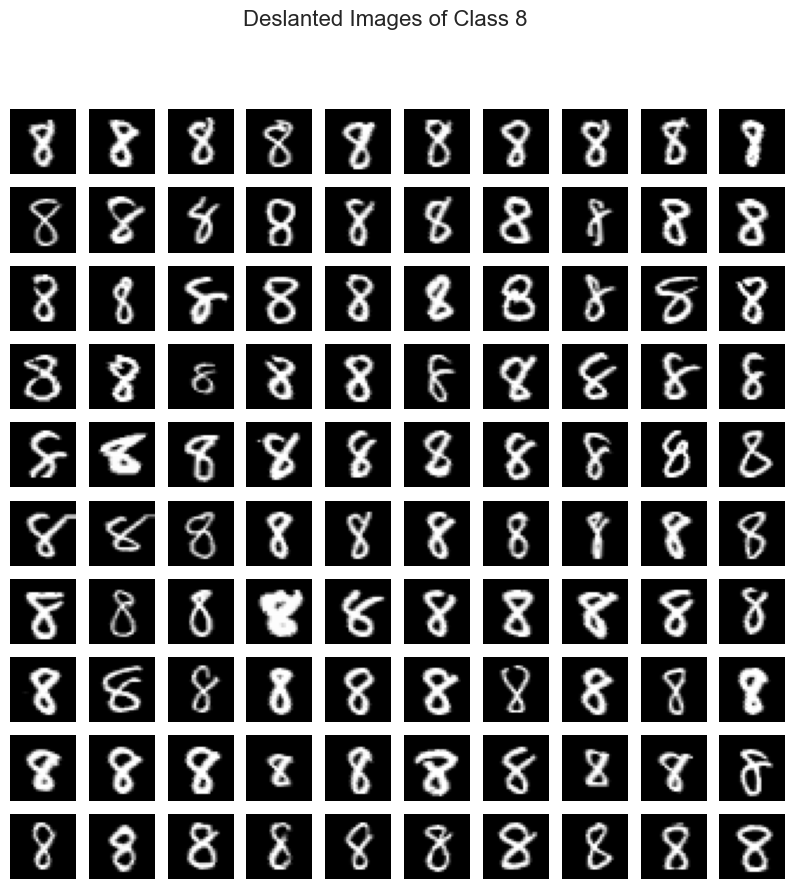

In [15]:
# Choose first 100 indices of class 8
class_8_indices = np.where(train_Y == 8)[0]

deslanted_train_X = deslant(flattened_train_X)

# Visualize the deslanted images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(deslanted_train_X[class_8_indices[i]].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Deslanted Images of Class 8', fontsize=16)


The data is now ready for training, let's train the model.

## Implementation

In [16]:
# compute nnet output
def compute_nnet_output(Ws, X, return_what="class"):
    """
    Compute the output of the neural network
    :param Ws: list of weight matrices
    :param X: input data
    :param return_what: what to return (class, probability or all)
    
    """

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    A = X
    As = [A]
    
    for W in Ws[:-1]:
        Z = A.dot(W)
        A = sigmoid(Z)
        A = np.hstack((np.ones((A.shape[0], 1)), A))
        As.append(A)
    
    Z = A.dot(Ws[-1])
    A = softmax(Z)
    As.append(A)
    
    if return_what == 'all':
        return As
    elif return_what == 'prob':
        return A
    else:
        return np.argmax(A, axis=1)

In [17]:
# train the neural network
def train_nnet(X, y, 
               hid_layer_sizes, 
               initial_Ws, mb_size, lr, max_epoch):
    """
    Train a neural network with error function as cross-entropy, softmax as output layer and optimized by SGD
    :param X: input data
    :param y: input labels
    :param hid_layer_sizes: list of number of neurons in hidden layers
    :param initial_Ws: initial weights
    :param mb_size: mini-batch size
    :param lr: learning rate
    :param max_epoch: maximum number of epochs
    """

    # Initialize the weights if not provided
    n_classes = len(np.unique(y)) 
    if initial_Ws is None:
        layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [n_classes]
        Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
              / np.sqrt(layer_sizes[i] + 1) 
              for i in range(len(layer_sizes) - 1)] 
    else:
        Ws = initial_Ws
    
    # Initialize the list of cross-entropy losses
    ces = []

    xrange = np.arange(len(X))      # Indexes of data samples
    n_loop = len(X) // mb_size      # Number of loops in each epoch (<= D / mb_size)

    for epoch in range(max_epoch):
        # Shuffle the data
        np.random.shuffle(xrange)
        
        # Loop through the data in mini-batches
        for i in range(n_loop):
            # Get the next mini-batch
            mb_X = X[xrange[i * mb_size:(i + 1) * mb_size]]
            mb_y = y[xrange[i * mb_size:(i + 1) * mb_size]]
            
            # Compute the outputs of all layers
            As = compute_nnet_output(Ws, mb_X, 'all')
            
            # Compute the prediction
            predicted_Y = As[-1]
            
            # One-hot encoding
            hot_encoding_y = np.eye(len(np.unique(y)))[mb_y]
            
            # Compute delta
            delta = predicted_Y - hot_encoding_y
            
            # compute the gradient of the last layer
            grad = As[-2].T.dot(delta) / mb_size
            
            # Update the weights of the last layer based on delta
            Ws[-1] -= lr * grad
            
            # Compute the gradients (perform back-propagation)
            grads = []
            for j in range(len(Ws) - 2, -1, -1):    
                delta = delta.dot(Ws[j + 1].T[:, 1:]) * As[j + 1][:, 1:] * (1 - As[j + 1][:, 1:])
                grad = As[j].T.dot(delta) / mb_size
                Ws[j] -= lr * grad
                
        # Compute the cross-entropy loss
        predicted_Y = compute_nnet_output(Ws, X, 'prob')
        hot_encoding_y = np.eye(len(np.unique(y)))[y]
        ce = -np.sum(hot_encoding_y * np.log(predicted_Y)) / len(X)
        ces.append(ce)            
    return Ws, ces


Now, let's train and evaluate the accuracy of this model
## Evaluation

In [18]:
# Preprocess the data
# flatten the images
flattened_train_X = train_X.reshape(train_X.shape[0], -1)
flattened_val_X = val_X.reshape(val_X.shape[0], -1)
flattened_test_X = test_X.reshape(test_X.shape[0], -1)

# Normalize the pixel values
train_Z = flattened_train_X / 255.0
val_Z = flattened_val_X / 255.0
test_Z = flattened_test_X / 255.0

# Deslant the images
train_Z = deslant(train_Z)
val_Z = deslant(val_Z)
test_Z = deslant(test_Z)


In [19]:
# Add intensity and symmetry features
train_intensity = compute_intensity(train_Z).reshape(-1, 1)
test_intensity = compute_intensity(test_Z).reshape(-1, 1)
val_intensity = compute_intensity(val_Z).reshape(-1, 1)

train_symmetry = compute_symmetry(train_Z).reshape(-1, 1)
test_symmetry = compute_symmetry(test_Z).reshape(-1, 1)
val_symmetry = compute_symmetry(val_Z).reshape(-1, 1)

train_Z = np.hstack((train_Z, train_intensity, train_symmetry))
test_Z = np.hstack((test_Z, test_intensity, test_symmetry))
val_Z = np.hstack((val_Z, val_intensity, val_symmetry))

# Add ones for bias
train_Z = np.hstack((np.ones((train_Z.shape[0], 1)), train_Z))
test_Z = np.hstack((np.ones((test_Z.shape[0], 1)), test_Z))
val_Z = np.hstack((np.ones((val_Z.shape[0], 1)), val_Z))

In [20]:
# Define the neural network
hid_layer_sizes = [128, 64]
initial_Ws = None
mb_size = 32
lr = 0.3
max_epoch = 50

# Train the neural network
Ws, ces = train_nnet(train_Z, train_Y, hid_layer_sizes, initial_Ws, mb_size, lr, max_epoch)


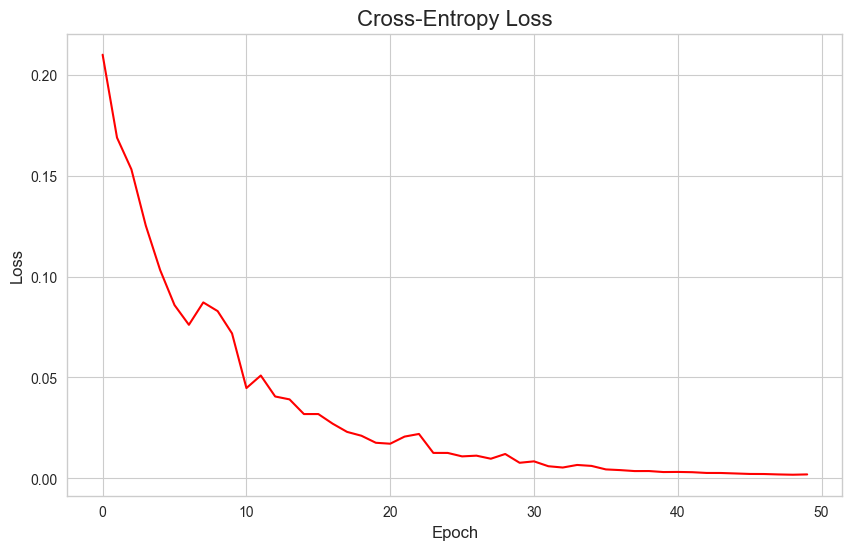

In [21]:
# Plot the cross-entropy loss
plt.figure(figsize=(10, 6))
plt.plot(ces, color='red')
plt.title('Cross-Entropy Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()

In [22]:
# Compute the accuracy
def compute_accuracy(Ws, X, y):
    predicted_Y = compute_nnet_output(Ws, X)
    return np.mean(predicted_Y == y)

# Compute the accuracy on the training set
train_accuracy = compute_accuracy(Ws, train_Z, train_Y)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Compute the accuracy on the validation set
val_accuracy = compute_accuracy(Ws, val_Z, val_Y)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Compute the accuracy on the test set
test_accuracy = compute_accuracy(Ws, test_Z, test_Y)
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9999
Validation Accuracy: 0.9837
Test Accuracy: 0.9848


This accuracy is good enough for a simple Neural Network model. \
Now, save this model for further usage.
## Save model

In [23]:
def save_model(Ws, filename="custom_mdoel.pkl"):
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    if (os.path.exists(filename)):
        print(f"Model file {filename} already exists. Do you want to overwrite it?")
        overwrite = input("Enter y/n: ")
        if overwrite.lower() != 'y':
            print("Model not saved.")
            return

    with open(filename, 'wb') as f:
        pickle.dump(Ws, f)
    print(f"Model saved as {filename}")

In [24]:
save_model(Ws, "custom_model.pkl")

Model saved as custom_model.pkl


## Testing cell

In [26]:
print(train_Z[0])

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         